In this notebook, SentenceTransformer is used to embed recommendation texts into vectors. Then AgglomerativeClustering is used to put similar recommendations into groups.

In [48]:
!pip install -U sentence-transformers
!pip install matplotlib
!pip --trusted-host github.com --trusted-host objects.githubusercontent.com install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.4.0/en_core_web_sm-3.4.0.tar.gz
!git -c http.sslVerify=false clone https://huggingface.co/sentence-transformers/all-mpnet-base-v2

  Using cached charset_normalizer-3.1.0-cp38-cp38-win_amd64.whl (96 kB)


ERROR: Could not install packages due to an OSError: [WinError 32] The process cannot access the file because it is being used by another process: '\\\\oitphchsmsmb6000b.va.gov\\vaco_users$\\vacofredrd\\desktop\\cmv-commitee-rec-nlp\\env\\Lib\\site-packages\\charset_normalizer\\md.cp38-win_amd64.pyd'
Check the permissions.



     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     -- ------------------------------------- 0.7/12.8 MB 11.2 MB/s eta 0:00:02
     --- ------------------------------------ 1.2/12.8 MB 10.9 MB/s eta 0:00:02
     ---- ----------------------------------- 1.5/12.8 MB 9.7 MB/s eta 0:00:02
     ----- ---------------------------------- 1.9/12.8 MB 9.3 MB/s eta 0:00:02
     ------- -------------------------------- 2.3/12.8 MB 9.1 MB/s eta 0:00:02
     -------- ------------------------------- 2.7/12.8 MB 9.5 MB/s eta 0:00:02
     --------- ------------------------------ 3.0/12.8 MB 9.2 MB/s eta 0:00:02
     ---------- ----------------------------- 3.5/12.8 MB 8.9 MB/s eta 0:00:02
     -

ERROR: Could not install packages due to an OSError: [WinError 32] The process cannot access the file because it is being used by another process: '\\\\oitphchsmsmb6000b.va.gov\\vaco_users$\\vacofredrd\\desktop\\cmv-commitee-rec-nlp\\env\\Lib\\site-packages\\charset_normalizer\\md.cp38-win_amd64.pyd'
Check the permissions.

Cloning into 'all-mpnet-base-v2'...
Updating files:  64% (9/14)
Updating files:  71% (10/14)
Updating files:  78% (11/14)
Updating files:  85% (12/14)
Updating files:  92% (13/14)
Updating files: 100% (14/14)
Updating files: 100% (14/14), done.


In [49]:
!pip install sacremoses

In [50]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.data_clean_functions import *

In [51]:
import numpy as np
import pandas as pd
import spacy
import re
from sklearn.cluster import AgglomerativeClustering
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sentence_transformers import SentenceTransformer
import pickle
#nlp = spacy.load("en_core_web_sm")

In [52]:
# load recommendation lists
recommd = pd.read_csv('CMV_Reports_Article_Recommendations_lists.csv')
recommd['RecommendLists'] = [i.split("&&") for i in recommd['Recommendations']]
print(recommd['RecommendLists'][0][:5])
# print(recommd.head())

['1. establish a separate budget line item for the advisory committee on minonty veterans.', '2. appropriate 125,000.00 for the fiscal year year budget for the advisory committee on minority veterans.', '3. recognize the appropnate regional and national minority organizations that serve our countrys diverse population proups and invite them as genuine partners, consultants, advisors and expert witnesses in enriching the departments commitment to serve the needs of our minomty veterans.', '4. authonze an assessment be conducted and a report submitted in fy 97 by the department of veterans affairs to determine the validity of the commuttees concern regarding ethnic representation on the rating panels and the ment review boards, as well as among the counselors who advise our minority veteran populations.', '5. establish and fund an intra agency task force, chaired by the director of the center for minonty veterans, to conduct a needs assessment for health care, benefits and compensation r

In [53]:
# check the number of recommendations and number of words in total
i = 0
j = 0
for red in recommd['RecommendLists']:
        i = i + len(red)
        for r in red:
#             if len(r.split(" ")) > 1143:
#                 print(r)
            j = j + len(r.split(" "))
        
print(i)
print(j)

259
11926


Use sentence encoders to embed recommendations into vectors. https://www.sbert.net/

In [54]:
# import tensorflow_hub as hub
# from sklearn.manifold import TSNE

# def embbedfn(text):
#     embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
# #     strsent = list(nlp(text).sents)
# #     strsent =  [str(onesentence) for onesentence in strsent if len(onesentence)>10]
#     embeddings = embed(text)
# #     mapped_embeddings = TSNE(n_components=2, metric='cosine', init='pca', verbose = 1).fit_transform(embeddingslocal)
#     return embeddings

def embbedbert(text, model):
    embeddings = model.encode(text)
    return embeddings

model = SentenceTransformer('all-mpnet-base-v2')

In [55]:
# bert sentence encoder
recommd['embeddings'] = recommd.RecommendLists.apply(lambda x: embbedbert(x, model))
recommd['embeddings'][0].shape

(16, 768)

In [56]:
# unlist the nested lists
# previous structure -> [[recommd1 for 1996, recommd2 for 1996, ...], [recommd1 for 1997, recommd2 for 1997, ...],...]
# current structure -> [recommd1 for 1996, recommd2 for 1996, ..., recommd1 for 1997, recommd2 for 1997, ...]
embeddings = []
for i in recommd['embeddings']:
    embeddings.extend(i)
RecommendLists = []
for i in recommd['RecommendLists']:
    RecommendLists.extend(i)
    
print(len(embeddings))
print(len(RecommendLists))

259
259


In [57]:
Years = []
for i in range(len(recommd['RecommendLists'])):
    Years.extend(list(np.repeat(recommd['Year'][i], len(recommd['RecommendLists'][i]))))
print(len(Years))

259


In [58]:
from sklearn import metrics
from sklearn.metrics import davies_bouldin_score
# davies_bouldin_score: ratio of within-cluster distances to between-cluster distances
# clusters which are farther apart and less dispersed will result in a better score.

Start parameter tuning for classification. There are many metrics used here for measuring classification performance. 
1. davies_bouldin_score: ratio of within-cluster distances to between-cluster distances. 
2. silhouette_score: The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.
3. calinski_harabasz_score: It is also known as the Variance Ratio Criterion. Ratio of the sum of between-cluster dispersion and of within-cluster dispersion.

In [59]:
# parameter tunings
# final output is a dataframe that stores all the parameters and their corresponding classification scores

def agg_cluster_tuning(grid):
    output = {'affinity': [],
             'linkage': [],
              'distance_threshold': [],
             'silhouette_score': [],
             'calinski_harabasz_score': [],
             'davies_bouldin_score': [],
             'number_of_clusters': []}
    for aff in grid['affinity']:
        for link in grid['linkage']:
            try: 
                clusterer = AgglomerativeClustering(n_clusters=None, affinity=aff, linkage=link, distance_threshold=0.2)
                clusterer.fit_predict(embeddings)
                dist = clusterer.distances_
                minD = min(dist)
                maxD = max(dist)
                step = (max(dist)-min(dist))/10
                for d in np.arange(minD+step, maxD, step):
    #                 print(d)
                    # fit
                    clusterer = AgglomerativeClustering(n_clusters=None, affinity=aff, linkage=link, distance_threshold=d)
                    clusters = clusterer.fit_predict(embeddings)
                    output['affinity'].append(aff)
                    output['linkage'].append(link)
                    output['silhouette_score'].append(metrics.silhouette_score(embeddings, clusters, metric='euclidean'))
                    output['calinski_harabasz_score'].append(metrics.calinski_harabasz_score(embeddings, clusters))
                    output['davies_bouldin_score'].append(davies_bouldin_score(embeddings, clusters))
                    output['distance_threshold'].append(d)
                    output['number_of_clusters'].append(max(clusters)+1)

            except:
                   pass
    return output
         

In [62]:
grid = {'affinity': ['euclidean', 'manhattan', 'l1', 'l2', 'cosine'],
           'linkage': ['ward', 'complete', 'average', 'single']}
# get the output dataframe 
output = pd.DataFrame(agg_cluster_tuning(grid))

KeyError: 'affinity'

In [ ]:
import datetime as dt
batch = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
batch 
output['batch'] = batch 
display(output)

affinity,linkage,distance_threshold,silhouette_score,calinski_harabasz_score,davies_bouldin_score,number_of_clusters,batch
euclidean,ward,0.522819964686148,0.081458,8.909780224381967,0.29861435674081016,239,20221101_215545
euclidean,ward,0.8696565304657948,0.13118882,3.369404163782129,0.9542508600590298,136,20221101_215545
euclidean,ward,1.2164930962454417,0.07941735,4.060183934043951,1.9802773052296285,45,20221101_215545
euclidean,ward,1.5633296620250885,0.05111963,5.103637178578343,2.6697664244857413,20,20221101_215545
euclidean,ward,1.9101662278047353,0.0303968,5.804964588325362,3.2051865402684006,12,20221101_215545
euclidean,ward,2.257002793584382,0.036869247,8.131639254918129,3.882162303293887,4,20221101_215545
euclidean,ward,2.603839359364029,0.02940096,12.747988527376576,4.09899813669416,2,20221101_215545
euclidean,ward,2.950675925143676,0.02940096,12.747988527376576,4.09899813669416,2,20221101_215545
euclidean,ward,3.2975124909233227,0.02940096,12.747988527376576,4.09899813669416,2,20221101_215545
euclidean,complete,0.2940685685018056,0.02660406,20.965222886211052,0.13763558042434038,254,20221101_215545


In [ ]:
# save output
with open('recommendation_parameter_tuning', 'wb') as fp:
    pickle.dump(output, fp)
# with open('/dbfs/NAII/CMV Reports/recommendation_parameter_tuning', 'rb') as fp:
#     output = pickle.load(fp)

In [ ]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In sum, calinski harabasz score and the number of clusters were used to make the final decision on the values for the parameters. I chose one combination that will have relative good calinski_harabasz_score and reasonable number of clusters. silhouette_score and davies_bouldin_score are used to provide extra informantion on the classification performance.

In [ ]:
clusterer = AgglomerativeClustering(n_clusters=None, affinity="euclidean", linkage="ward", distance_threshold = 1.25)
clusters = clusterer.fit_predict(embeddings)

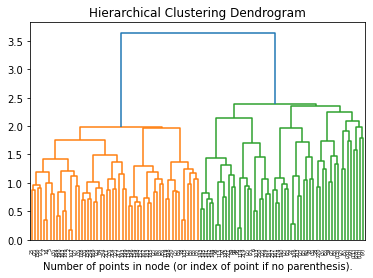

In [ ]:
# plot hierarchical clustering dendrogram
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(clusterer, truncate_mode='level', p=6)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [ ]:
output.to_csv('CMV_Reports_Article_Recommendations_clusters')

In [ ]:
# plot of clusters in 2D
from sklearn.manifold import TSNE
from collections import Counter
mapped_embeddings = TSNE(n_components=2, metric='euclidean', init='pca').fit_transform(embeddings)

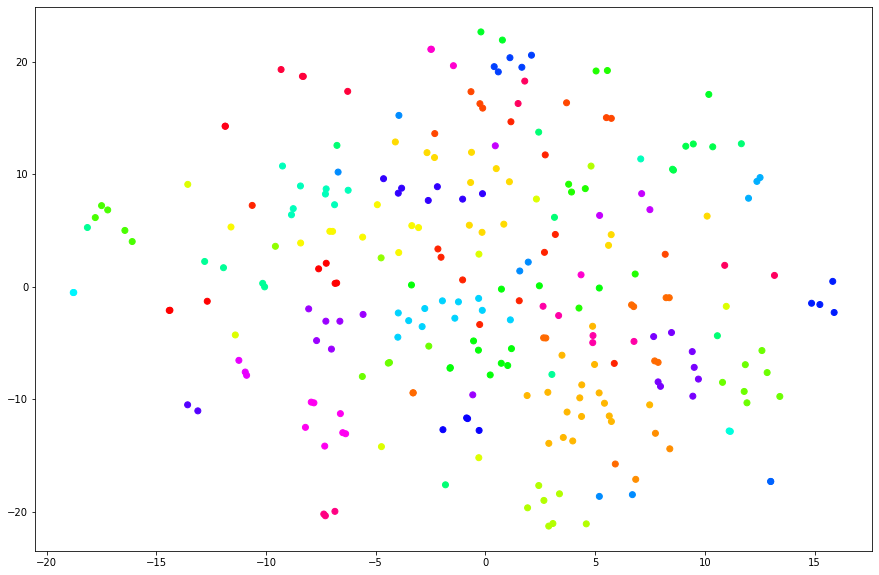

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,10))
x = mapped_embeddings[:,0]
y = mapped_embeddings[:,1]
ax.scatter(x, y, c = clusters, cmap = 'hsv')
# ax.legend(clusters, title='clusters')
plt.show()

In [ ]:
# present the distribution of clusters: number of recommendations in each cluster
display(pd.DataFrame({'cluster': [i for (i,j) in Counter(clusters).most_common()], 'freq': [j for (i,j) in Counter(clusters).most_common()]}))

cluster,freq
5,17
6,13
14,12
3,11
1,11
22,11
11,11
19,9
7,9
2,8


In [ ]:
# create the output table with 3 columns: recommendation text, clusters and years
recommd_cluster = pd.DataFrame({"text": RecommendLists, "cluster": clusters, 'Years': Years})
display(recommd_cluster.loc[recommd_cluster['cluster'] == 5])

text,cluster,Years
"4. authorize an assessment be conducted and a report submitted in by 97 by the department of veterans affairs to determine the validity of the committees concern regarding ethnic representation on the rating panels and the men review boards, as well as among the counselor who advise our minority veteran populations.",5,1996
52. initiate a system to collect on going statistical data on minority veterans who are treated as inpatients on the va psychiatric wards at triple army medical center.,5,1997
"recommendation 4 there is a perception, from the meeting in new orleans, of unfair ratings of minority veterans compared to whites. the va regional office is aware of this claim and is looking into the matter.",5,2004
"recommendation 7 va expeditiously complies with the va acting general counsel opinion, subject webcams 372917 collection of veterans ethnic and racial demographic data, datedmonth2, year.",5,2007
"recommendation 15 the secretary directs vha, vba, and inca to collect demographic data throughout the va, in accordance, with the va acting general counsel opinion, subject webcams 372917 collection of veterans ethnic and racial demographic data, datedmonth2, year, and inform the acmv, on the status of the demographic data collection, by the next acme meeting in washington, dc.",5,2008
"recommendation 17 that the department of veterans affairs expeditiously implements the va acting general counsel opinion opinion , datedmonth2, year, which requires the va to collect ethnic and racial demographic data, from the veteran population that it serves, by voluntary self identification.",5,2008
recommendation 18 via provide information that reflects if minority veterans are identified with having pts or other diagnoses in percentages proportional to their military population.,5,2008
recommendation 4 that the va office of human resources and administration develop a methodology to determine the reasons causes of removals terminations regrettable losses of recently hired minority veterans by the end of fiscal year 2074.,5,2013
"recommendation 5 that va expedite the collection and analysis of demographic data on minority veterans to determine if disparities exists in the top five claimed conditions, grant rate for disability claims, and percentages of disability granted, and publish a report similar to the review that was recently completed on women veterans by year.",5,2013
"recommendation 3 that the va update the schedule for rating disabilities part 4, title 38 code of federal regulations to accommodate medical research on symptomatology of certain medical conditions which have particular application to minority veterans of differing cultures.",5,2014


In [ ]:
# save recommd_cluster
with open('recommendation_clusters', 'wb') as fp:
    pickle.dump(recommd_cluster, fp)
# with open('/dbfs/NAII/CMV Reports/recommendation_clusters', 'rb') as fp:
#     recommd_cluster = pickle.load(fp)

In [ ]:
import plotly.express as px

recommd_cluster['cluster'] = recommd_cluster['cluster'].astype(str)
fig = px.scatter(recommd_cluster, y="Years", x="cluster", color="cluster")

fig.show()

Generate recommendation summary text for each cluster

In [ ]:
# first concatenate all the text strings from the same cluster
dfCluster = recommd_cluster[['cluster', 'text']].groupby('cluster')['text'].apply(' '.join).reset_index()

NameError: name 'recommd_cluster' is not defined

In [ ]:
# use Bart large cnn model for text summarization
import torch
import tensorflow_hub as hub

bart = torch.hub.load('pytorch/fairseq', 'bart.large.cnn')
def allsummary(body):
    summarystr = str(bart.sample(body, beam=4, lenpen=2.0, max_len_b=240, min_len=100, no_repeat_ngram_size=5))
    return summarystr

dfCluster['summarytxt'] = dfCluster.text.apply(allsummary)
display(dfCluster)

ModuleNotFoundError: No module named 'tensorflow_hub'

In [ ]:
# write to delta lake
recommd_cluster.to_csv('CMV_Reports_Article_Recommendations_df.csv')
dfCluster.to_csv('CMV_Reports_Article_Recommendations_dfCluster.csv')

NameError: name 'recommd_cluster' is not defined